# 1 Гибридное шифрование
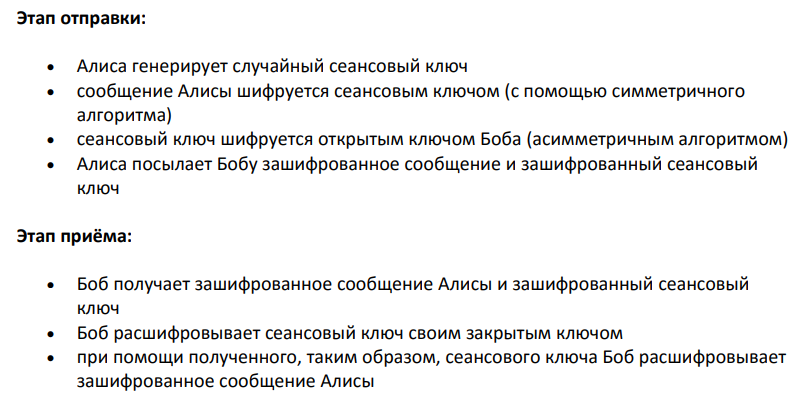

In [1]:
from Crypto.PublicKey import RSA
from Crypto import Random
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Cipher import AES
import base64
import hashlib
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import unpad, pad

class RSACipher:

    @staticmethod
    def encrypt(message, public_key):
        rsa_public_key = RSA.importKey(public_key)
        rsa_public_key = PKCS1_OAEP.new(rsa_public_key)
        encrypted_text = rsa_public_key.encrypt(message)
        return encrypted_text
        
    @staticmethod
    def decrypt(encrypted_text, private_key):
        rsa_private_key = RSA.importKey(private_key)
        rsa_private_key = PKCS1_OAEP.new(rsa_private_key)
        decrypted_text = rsa_private_key.decrypt(encrypted_text)
        return decrypted_text

In [2]:
class AESCipherECB():
    
    def __init__(self, key):
        self.key = hashlib.md5(key).digest()
        
    def encrypt(self, msg):
        cipher = AES.new(self.key, AES.MODE_ECB)
        raw = pad(msg, AES.block_size)
        enc = cipher.encrypt(raw)
        # return base64.b64encode(enc).decode('utf-8')
        return enc

    def decrypt(self, msg):
        cipher = AES.new(self.key, AES.MODE_ECB)
        dec = cipher.decrypt(msg)
        return unpad(dec, AES.block_size)
    
class Alice:
    def __init__(self, Bob_pk):
        self.session_key = get_random_bytes(AES.block_size) # Alice's session key
        self.receiver_pk = Bob_pk # Bob's key
        print("[Alice]: сгенерирован сеансовый ключ, получен публ.ключ RSA Боба:", self.receiver_pk)

    # Encrypt msg with session key
    def encrypt_msg(self, msg):
        return AESCipherECB(self.session_key).encrypt(msg)
    
    # Encrypt session key with Bob key
    def encrypt_key(self):
        return RSACipher().encrypt(self.session_key, self.receiver_pk)
    
    def send_mess(self, msg):
        b_msg = bytes('hey, Bob', encoding='utf-8')
        enc_key = self.encrypt_key()
        enc_mess = self.encrypt_msg(bytes(b_msg))
        print("[Alice]: зашифрован сеанс.ключ:",enc_key,"\nЗашифровано сообщение:",enc_mess)
        return enc_key, enc_mess

class Bob:
    def __init__(self):
        key_couple = RSA.generate(4096, e=65537)
        self.__private_key = key_couple.exportKey('PEM')
        self.public_key = key_couple.publickey().exportKey('PEM')

    def decrypt_msg(self, msg, key):
        return AESCipherECB(self.decrypt_session_key(key)).decrypt(msg)
    
    # Decrypt session key
    def decrypt_session_key(self, key):
        return RSACipher().decrypt(key, self.__private_key)

    def get_msg_from_sender(self, key, msg):
        # Get mess and decrypt it
        mess = str(self.decrypt_msg(msg, key))
        print("[Bob]:расшифровано сообщение от Алисы", mess)
        return mess

B = Bob()
A = Alice(Bob_pk = B.public_key)
message = 'hey, Bob'
key_, mess_ = A.send_mess(message)
B.get_msg_from_sender(key_ , mess_)

[Alice]: сгенерирован сеансовый ключ, получен публ.ключ RSA Боба: b'-----BEGIN PUBLIC KEY-----\nMIICIjANBgkqhkiG9w0BAQEFAAOCAg8AMIICCgKCAgEArGsNu6V6yOnifSaGFDcL\nzUP83s1suhrFjpwt41ji8i+CL1M08xrdTNlvpBjIyQ/tM/Uugquy4ng56rDEUYMW\nFxRKP0+J3mm/9ThY+Azm+pQ7w+R8ynpwcXhv5Ibb/3HTH9P5iNeTNgzzfqj7Itpl\nvo7euyut8cCZyH0EsvmuRXEuZQt2gejEJj/eTxoZD1QrARy9JDRQ1vO5M3G3BXyt\nB4MXnvJHIvz+XLREmVgOjR2mZHm4gvh6+/dhbUqx+avwMACIC/FM/NIqe182S/6W\n20x0geYSfn24gmWqrV3gvb1+BcwyWxL9bOx6yt26Pj5ltCLzOnhF7YTbeqaqZtLQ\nVrOQ1ebj9IGduA/4ZcZBH1iyZfCQseKhUPV1YDLaTht7LUZGUHIz92S88xT1d7oS\niCQwjjqFK5CN1odTY0yARdvR2T5vzPjYX+LkLUS7y356JKt9ICAu0Xps6GIK730E\nb1bpJmhJgGL/TRXf8kNxnNi872UVQp+RqFzKjWmvxGIkvGUFKrV2frgc0cMh+N+g\nDyNd5dQw6YXy+WrvzhEX7ZEcfaQY2EtUHhgZBc90BrIeHyX5qOUitYW85+h3LhZq\nln4HMspjkrOUePIVWwoR/hhxxwvX1/LWgBJdoNUZSSKfufM/fnF2xDEJUXYQiiM5\nU7K3JFGrHVYAUkRPT3prrnUCAwEAAQ==\n-----END PUBLIC KEY-----'
[Alice]: зашифрован сеанс.ключ: b'4\xb9\xcf\xf5^\x01\xac\xcbo4f)7\xbb\x93*i*[\xfb\x89L%\xc3\x17\xe7\x02aD\xa6c\xe3\xdc

"b'hey, Bob'"

# 2
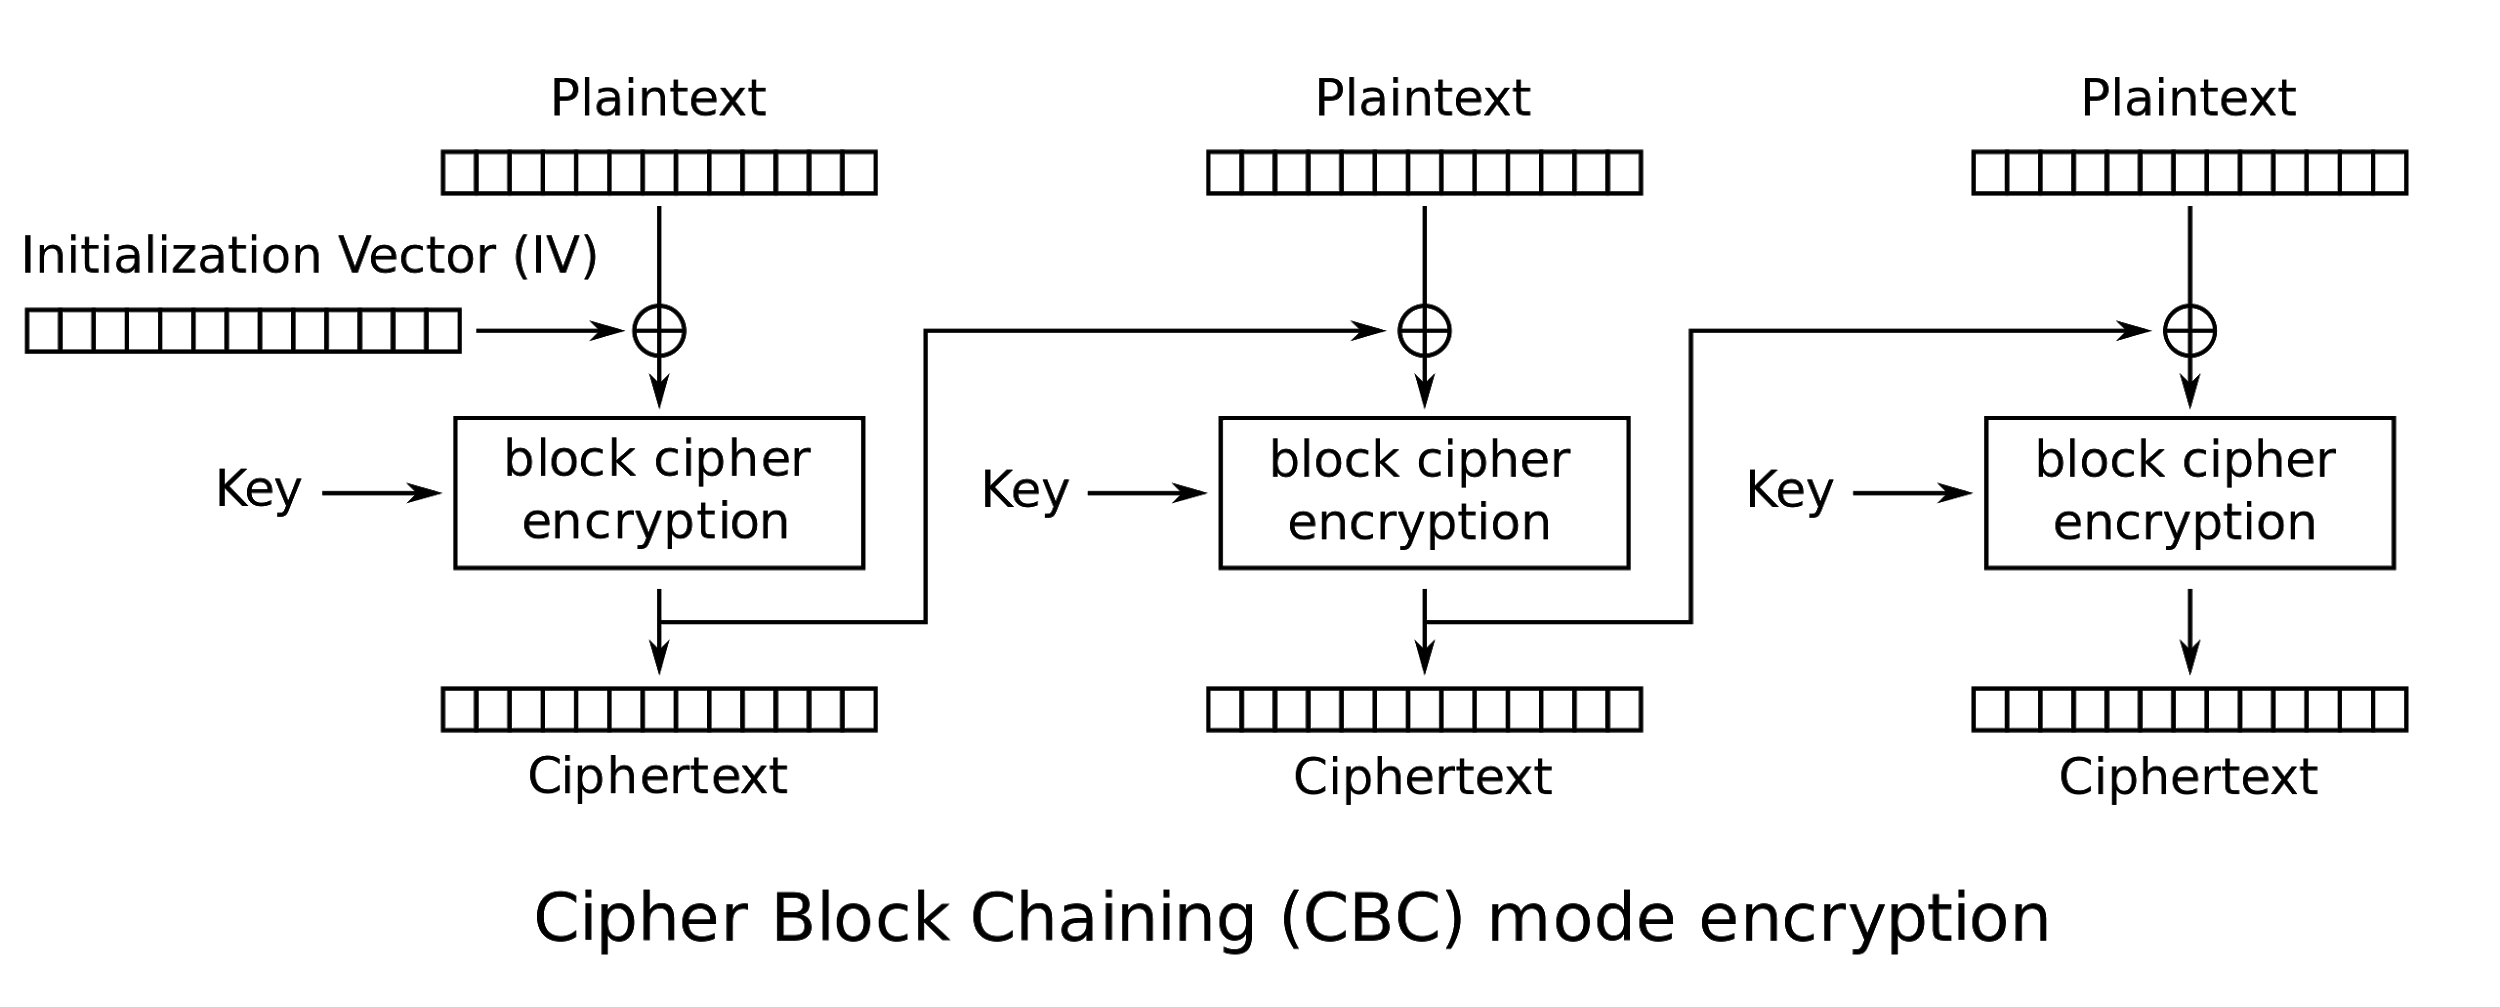
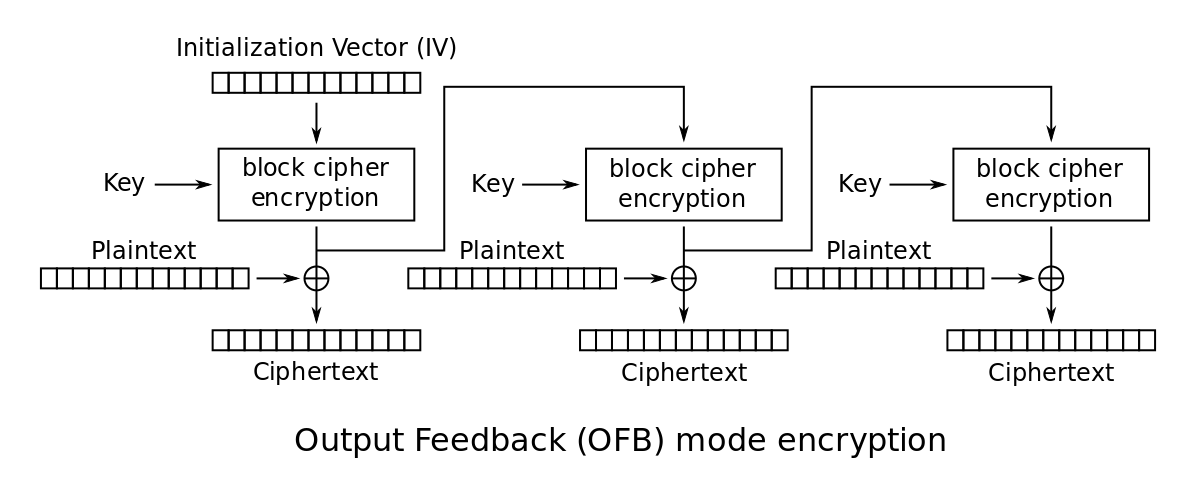
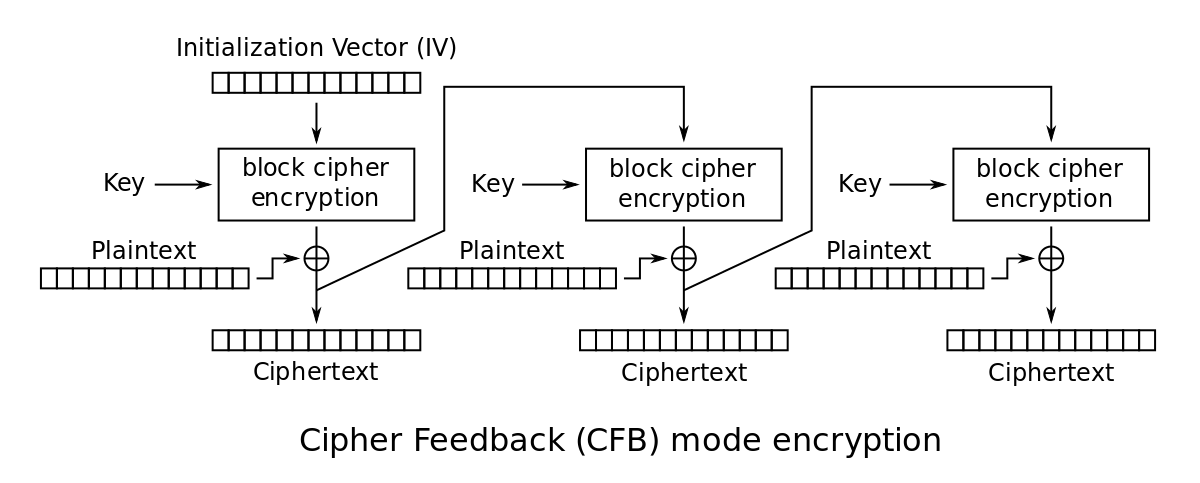

In [3]:
class AESCBC():
    
    def __init__(self, key):
        self.key = hashlib.md5(key).digest()
        
    def encrypt(self, msg):
        IV = get_random_bytes(AES.block_size)
        cipher = AES.new(self.key, AES.MODE_CBC, IV)
        raw = pad(msg, AES.block_size)
        enc = cipher.encrypt(raw)
        return IV+enc

    def decrypt(self, msg):
        IV = msg[:AES.block_size]
        cipher = AES.new(self.key, AES.MODE_CBC, IV)
        ct = msg[AES.block_size:]
        print("IV:",IV,"\nCT:",ct)
        dec = cipher.decrypt(ct)
        return unpad(dec, AES.block_size)
    
class AESOFB():
    def __init__(self, key):
        self.key = hashlib.md5(key).digest()
        
    def encrypt(self, msg):
        IV = get_random_bytes(AES.block_size)
        cipher = AES.new(self.key, AES.MODE_OFB, IV)
        raw = pad(msg, AES.block_size)
        enc = cipher.encrypt(raw)
        return IV + enc

    def decrypt(self, msg):
        IV = msg[:AES.block_size]
        cipher = AES.new(self.key, AES.MODE_OFB, IV)
        dec = cipher.decrypt(msg[AES.block_size:])
        return unpad(dec, AES.block_size)
    
class AESCFB():
    def __init__(self, key):
        self.key = hashlib.md5(key).digest()
        
    def encrypt(self, msg):
        IV = get_random_bytes(AES.block_size)
        cipher = AES.new(self.key, AES.MODE_CFB, IV)
        raw = pad(msg, AES.block_size)
        enc = cipher.encrypt(raw)
        return IV + enc

    def decrypt(self, msg):
        IV = msg[:AES.block_size]
        cipher = AES.new(self.key, AES.MODE_CFB, IV)
        dec = cipher.decrypt(msg[AES.block_size:])
        return unpad(dec, AES.block_size)

In [4]:
class Alice:
    def __init__(self, AES_type, Bob_pk):
        print("\n----------",str(AES_type.__name__))
        self.session_key = get_random_bytes(AES.block_size) # Alice's session key
        self.receiver_pk = Bob_pk # Bob's key
        self.AES_type = AES_type
        print("[Alice]: сгенерирован сеансовый ключ, получен публ.ключ RSA Боба:", self.receiver_pk)

    # Encrypt msg with session key
    def encrypt_msg(self, msg):
        return self.AES_type(self.session_key).encrypt(msg)
    
    # Encrypt session key with Bob key
    def encrypt_key(self):
        return RSACipher().encrypt(self.session_key, self.receiver_pk)
    
    def send_mess(self, msg):
        print("\n[Alice]: отправляется сообщение:", msg)
        b_msg = bytes(msg, encoding='utf-8')
        enc_key = self.encrypt_key()
        enc_mess = self.encrypt_msg(bytes(b_msg))
        print("[Alice]: зашифрован сеанс.ключ:",enc_key,"\nЗашифровано сообщение:",enc_mess)
        return enc_key, enc_mess

class Bob:
    def __init__(self, AES_type):
        key_couple = RSA.generate(4096, e=65537)
        self.__private_key = key_couple.exportKey('PEM')
        self.public_key = key_couple.publickey().exportKey('PEM')
        self.AES_type = AES_type

    def decrypt_msg(self, msg, key):
        return self.AES_type(self.decrypt_session_key(key)).decrypt(msg)
    
    # Decrypt session key
    def decrypt_session_key(self, key):
        return RSACipher().decrypt(key, self.__private_key)

    def get_msg_from_sender(self, key, msg):
        # Get mess and decrypt it
        mess = str(self.decrypt_msg(msg, key))
        print("\n[Bob]:расшифровано сообщение от Алисы", mess)
        return mess

    
types = [AESCBC, AESOFB, AESCFB]
for aes_type in types:
    B = Bob(aes_type)
    A = Alice(aes_type, Bob_pk = B.public_key)
    message = 'hey, Bob'
    key_, mess_ = A.send_mess(message)
    B.get_msg_from_sender(key_, mess_)


---------- AESCBC
[Alice]: сгенерирован сеансовый ключ, получен публ.ключ RSA Боба: b'-----BEGIN PUBLIC KEY-----\nMIICIjANBgkqhkiG9w0BAQEFAAOCAg8AMIICCgKCAgEAugC6CENB66MM+N3rCAvb\nX5eXGYIEyd0uxNr6cWnvEX+xkg0xJISgKrV8PbP5otLh9tzIH/Auibyh8gcEkvui\nH1N/TGH8+wpuBflHyxm2IG4BDYUxlgMithNpGt/rXXNdlFBvn5Kt+mH11n5wn0QZ\nmyD8F2/NoNvFRoQYGXLIV0oq/FlSF8VevJoapbPm5XzhStJdtZm/6N53tfjkSqY5\nmaZhjhDHrsKYLFRz5mOldKcECOWFxk4PiMN4dr4MEBlyjpNO5LEMP9MnGS/+casO\ncpDFtKqopZ2/vx9EL5UREqt0wDWHziKz/BxIG3oBRoMIh3C7qwi9BIUs/whdt69q\nC7xQZD3sgGy2n2wDKJQVroucjt9wPq9xA/BHplmZ1FzUJB8fC1Tpklzs+/bzOrFM\nn7X2rgu1p81x0uK4lKwir8Bn3jBPaDx2tcXdScO70FbQmGQdCK+GM7BAwVDVhlvi\nwHi/QC2EldMRSorE8QMhUBQPs4Vs01UQUfkwAfHb+bnFIfwdj1kxc+8MAmISPXMp\nGPkU1Q8dSruZnqwcvt1Fd+vuzX/r0EibOVEsAvSlqINkbwijlyulkoQudnli5PI1\n8zKTqM3H395hlOuzutzuKF+V5rDlC9FW6SGJSg0KqxvuwFhMgSwV5BQCiMUzVah9\nd7eyIaNFyrC+TBXd3vtTylkCAwEAAQ==\n-----END PUBLIC KEY-----'

[Alice]: отправляется сообщение: hey, Bob
[Alice]: зашифрован сеанс.ключ: b'\x90\x92\xf5\x88\xb8\x

# 3 (2. Encrypt-and-Mac)
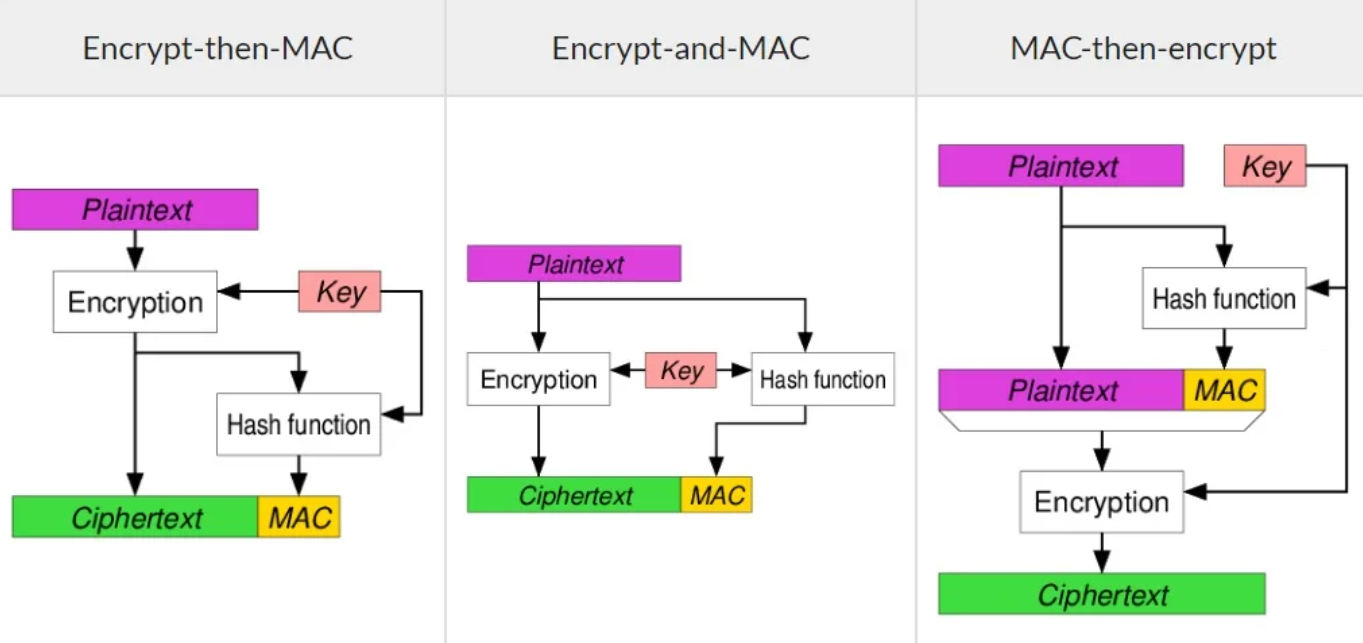

In [6]:
import hmac

class AESECB_Enc_and_Mac():
    def __init__(self, key):
        self.key = hashlib.md5(key).digest()
        
    def encrypt(self, msg):
        key = self.key[:AES.block_size]
        mac_key = self.key[AES.block_size:]
        
        cipher = AES.new(key, AES.MODE_ECB)
        raw = pad(msg, AES.block_size)
        mac = hmac.new(mac_key, msg=msg, digestmod=hashlib.sha512).digest()
        enc = cipher.encrypt(raw)
        return enc, mac

    def decrypt(self, mess):
        enc_key = self.key[:AES.block_size]
        mac_key = self.key[AES.block_size:]
        
        enc, mac = mess[0], mess[1]
        cipher = AES.new(enc_key, AES.MODE_ECB)
        dec = cipher.decrypt(enc)
        msg = unpad(dec, AES.block_size)
        
        true_mac = hmac.new(mac_key, msg=msg, digestmod=hashlib.sha512).digest()
        if mac == true_mac:  
            print("-- проверка hmac:",mac,"=\n",true_mac)
            return msg
        return None


B = Bob(AESECB_Enc_and_Mac)
A = Alice(AESECB_Enc_and_Mac, Bob_pk = B.public_key)
message = 'hey, Bob'
key_, mess_ = A.send_mess(message)
B.get_msg_from_sender(key_ , mess_)


---------- AESECB_Enc_and_Mac
[Alice]: сгенерирован сеансовый ключ, получен публ.ключ RSA Боба: b'-----BEGIN PUBLIC KEY-----\nMIICIjANBgkqhkiG9w0BAQEFAAOCAg8AMIICCgKCAgEArbGHJba4mezDyMOujf3H\ntN/aXzpAAWGwn80CoPepRq7yWvfmzKE/jJsLczPOGTM5ILNypWMnpkuE0rnsqFAQ\nlxMLCNstdGoetleOU1b+EWMioIBH6ZfV/T9vIzYO3Nq5D9X2UrgtmPdF8HLFv4qE\nkN8Uz9xgGy5ZxOB1AMU6OXVbaCyUmbPXQ+3+lZjqqnoofF0tg51EvxJATWckG3IT\n1YXA6Ew7IqcRmWgV4vwLK6hJu7Rp6OufXkJJRuMT4+W4pNU1b70lcxUYSH99+46S\naEvUO3WsVMOvsovbiDEGJOQL7zpEnwxEvq3ZhnLYQ5c1BrVgi8qGCuPsnuY5ZT8S\nxC80fxRnRGLcMzcJ9bm246VViE7ncJday1u1BmlbrLVEMnHlICqHoHm5S7Jm2Qzh\npTKHSWp2UA8gnk0nY2Iu/vrPF7AR7Q7GJ1DYiIl978Te7Vli9HMaftYyxVSwJNL8\nAWqMP99E1/PxO99bvlfRacws/1r6+SxOK35VD9G304xZoRwB8o345E01vmD0w8uR\nud9r5dFpg7bRDV67jcBNOJF+3Tq1wUiXv/+NqqKq8Cia9jo+yCEeWFltlp5s2gvt\nd0iTzHdoOd7/a8/pR0h4q4ft2k6GgF2S6gD5E8L/dUMeq9i+Nrud4JBX5P2wHuSv\nr6j6Hg6m313xnLNmURuhn1UCAwEAAQ==\n-----END PUBLIC KEY-----'

[Alice]: отправляется сообщение: hey, Bob
[Alice]: зашифрован сеанс.ключ: b'a#\xc6#3Q\

"b'hey, Bob'"

# 4  OCB (Offset codebook)
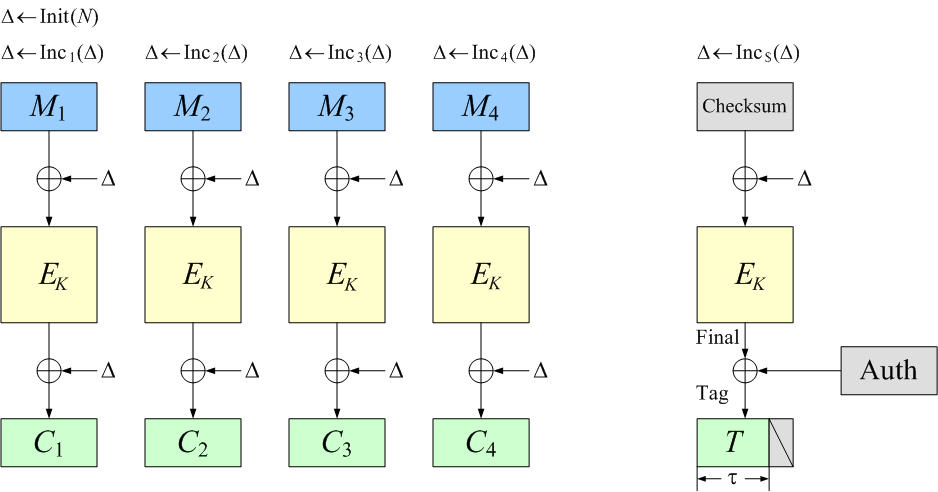
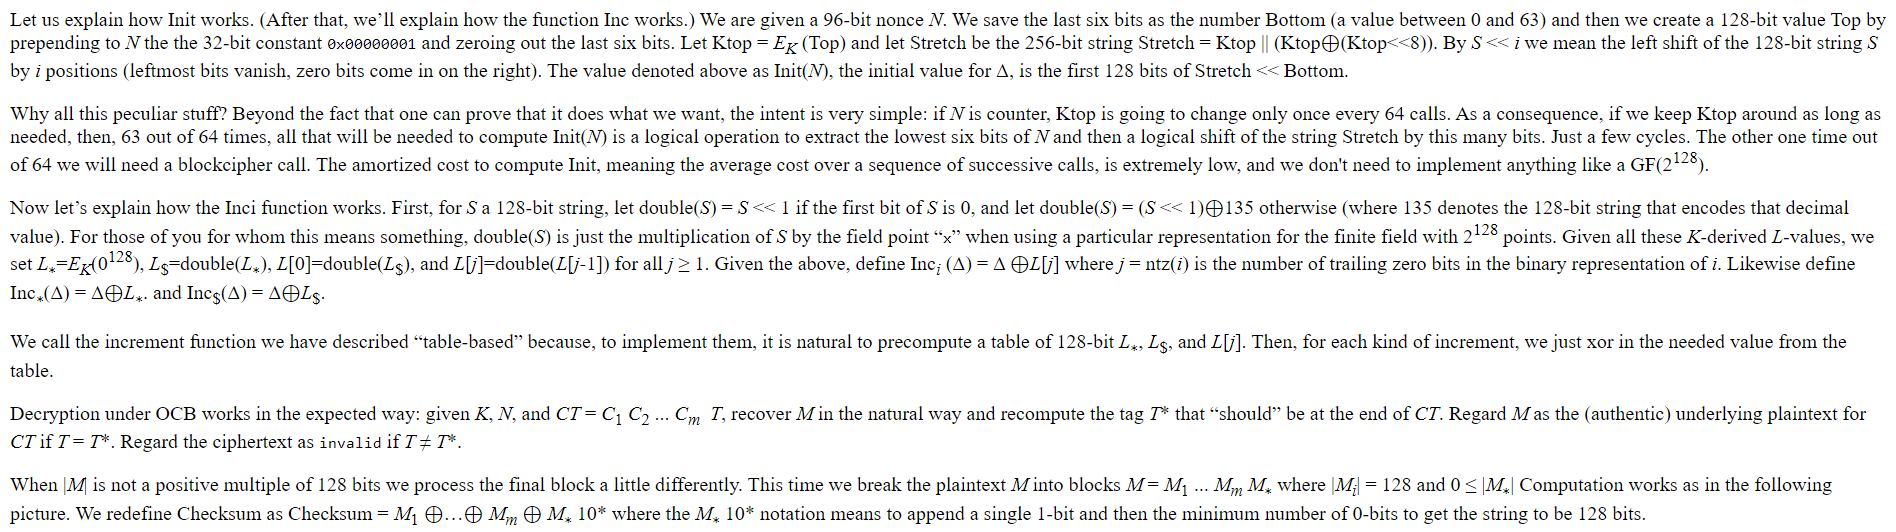
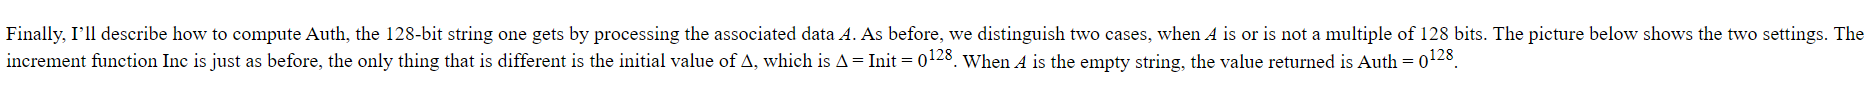

In [13]:
import hmac

class AESOCB_Enc_and_Mac():
    def __init__(self, key):
        self.key = hashlib.md5(key).digest()

    def encrypt(self, msg):
        key = self.key[:AES.block_size]
        mac_key = self.key[AES.block_size:]
        nonce = get_random_bytes(15)

        cipher = AES.new(key, AES.MODE_OCB, nonce = nonce)
        raw = pad(msg, AES.block_size)
        mac = hmac.new(mac_key, msg=msg, digestmod=hashlib.sha512).digest()
        enc = cipher.encrypt(raw)
        return nonce + enc, mac

    def decrypt(self, mess):
        enc_key = self.key[:AES.block_size]
        mac_key = self.key[AES.block_size:]
        
        nonce_enc, mac = mess[0], mess[1]
        nonce = nonce_enc[:15]
        enc = nonce_enc[15:]
        
        cipher = AES.new(enc_key, AES.MODE_OCB, nonce = nonce)
        dec = cipher.decrypt(enc)
        msg = unpad(dec, AES.block_size)
        
        true_mac = hmac.new(mac_key, msg=msg, digestmod=hashlib.sha512).digest()
        if mac == true_mac:  
            print("-- проверка hmac:",mac,"=\n",true_mac)
            return msg
        return None


B = Bob(AESOCB_Enc_and_Mac)
A = Alice(AESOCB_Enc_and_Mac, Bob_pk = B.public_key)
message = 'hey, Bob'
key_, mess_ = A.send_mess(message)
B.get_msg_from_sender(key_ , mess_)


---------- AESOCB_Enc_and_Mac
[Alice]: сгенерирован сеансовый ключ, получен публ.ключ RSA Боба: b'-----BEGIN PUBLIC KEY-----\nMIICIjANBgkqhkiG9w0BAQEFAAOCAg8AMIICCgKCAgEA4bNE/mB5HBFmkvUedeWy\nXSznSm1fCJeI7VxCjRvzjL0ch+AoyF3if2BVSfGMg2/f8ENGzyQxFjD448zWGx/y\ngBUprbEZXkmujUm/faneoYL1m+dMXgm+jAtYwFaj3sj2EIOfK5aAWzOodvsW4q/N\n+xmxuPRw99TXXe16Fo9TBUNmN6v1/3YW4cPNSpDtIz+NTRzTqNAP2mw/fZucKxEM\nNpvVpopsLO5JBMPY+s3YEs6HnkduCm+aazQltEcyxEmGE0cJOrWfZczO3cXOl2C3\na0oPe+ZnU9hDYYrdv64SKLG3JGkfqMrU106ePH1iiI9WULEBrtjhiT/9FydIDA1j\nPaIjvUBL8AQh2yQZ3oO/+p8RB4CGfSBaAIeSVbnr9BpY1ZgOPr8QlVW/dCfQVHld\nQF7UeoA7/rca6QQceDnW8c4iYMeWLY9N03vuUD8qx15PAtCA5IFocw4rvVB/gJFn\n+Yu6BjYvLqF8+t9o330Z+lHEVxkh/lrO5sWujLQEGCYucXjYxrPvaaR2YvQu7Bl6\nMV9r56/fnY4L1/nSrKlajTteCwbPhSnzGOlpSNwZOZcFS5dZI+cH1tAAjjQ+YyVY\nwUf2+ApglbeNCI6D3uSX8D2OYs4ZXO7CLnDlT7gbubdPpHSuRXSiBTPwwKJuP68F\nOxfFZaM71VFBx+TJewUF4gsCAwEAAQ==\n-----END PUBLIC KEY-----'

[Alice]: отправляется сообщение: hey, Bob
[Alice]: зашифрован сеанс.ключ: b"\xc2,\x17\

"b'hey, Bob'"

Напоминает CTR
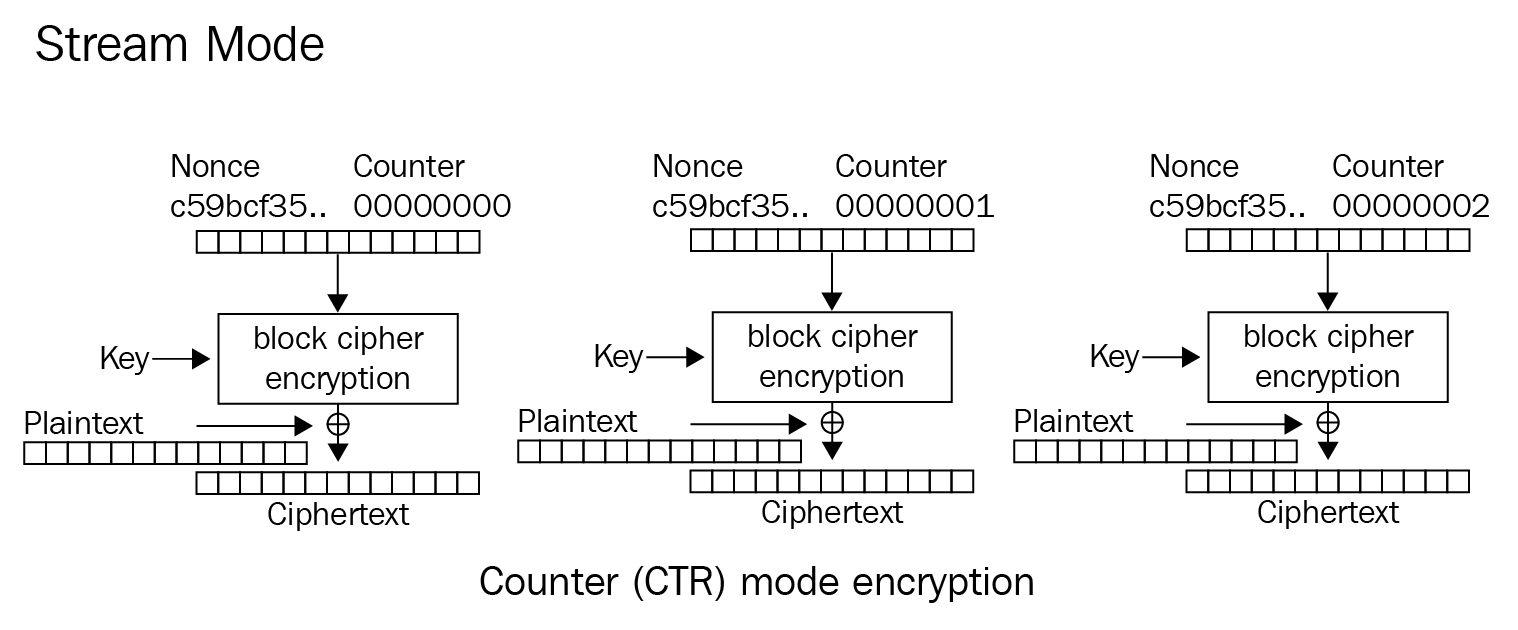